
Initial Matchup Data:
         Team A           Team B  Win Prob A  Win Prob B  Seed A  Seed B
           Duke Mount St. Mary's    0.994663    0.005337       1      16
        Alabama    Robert Morris    0.950324    0.049676       2      15
      Wisconsin          Montana    0.952144    0.047856       3      14
        Arizona            Akron    0.891537    0.108463       4      13
         Oregon          Liberty    0.663413    0.336587       5      12
            BYU              VCU    0.521589    0.478411       6      11
   Saint Mary's       Vanderbilt    0.719099    0.280901       7      10
Mississippi St.           Baylor    0.490916    0.509084       8       9

Simulating: Duke vs Mount St. Mary's (Seed 1 vs Seed 16)


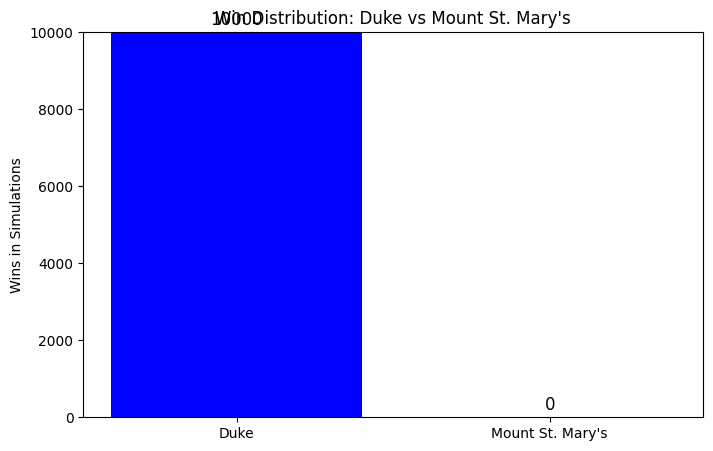


Simulating: Alabama vs Robert Morris (Seed 2 vs Seed 15)


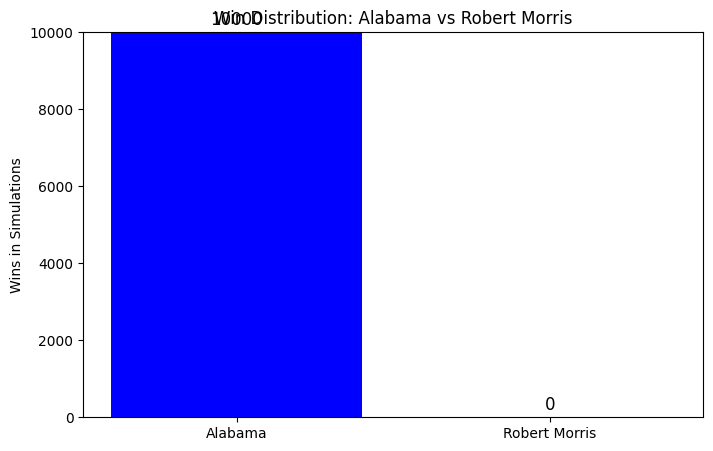


Simulating: Wisconsin vs Montana (Seed 3 vs Seed 14)


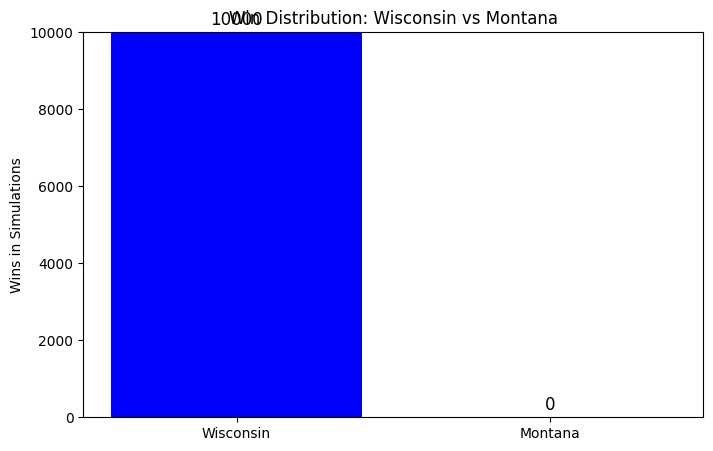


Simulating: Arizona vs Akron (Seed 4 vs Seed 13)


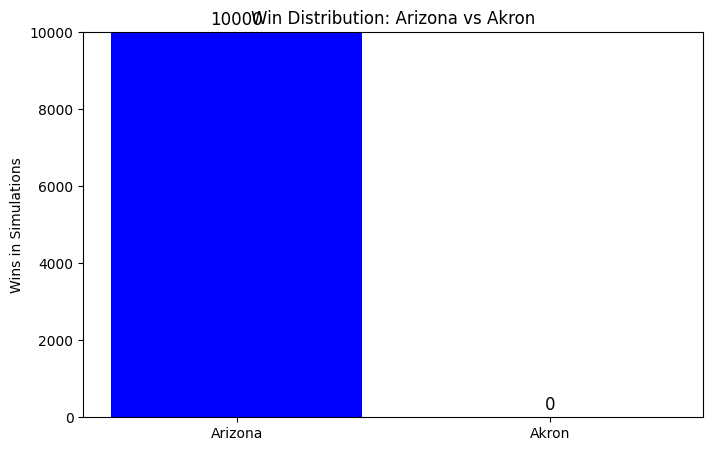


Simulating: Oregon vs Liberty (Seed 5 vs Seed 12)


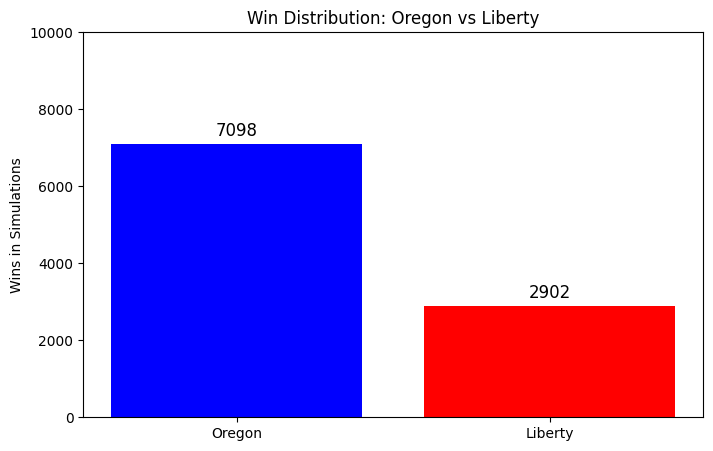


Simulating: BYU vs VCU (Seed 6 vs Seed 11)


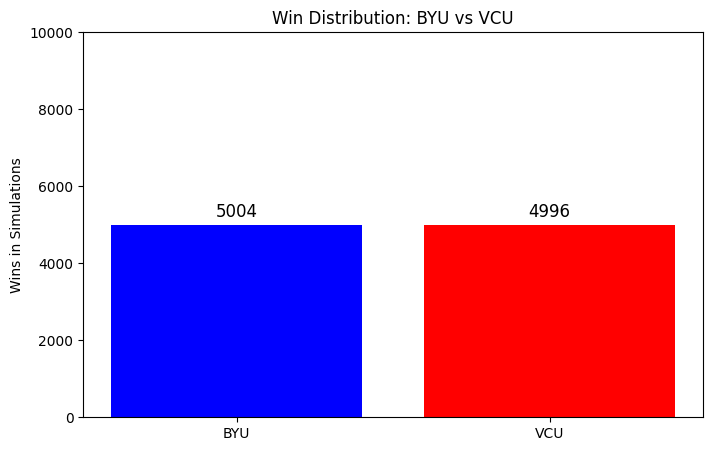


Simulating: Saint Mary's vs Vanderbilt (Seed 7 vs Seed 10)


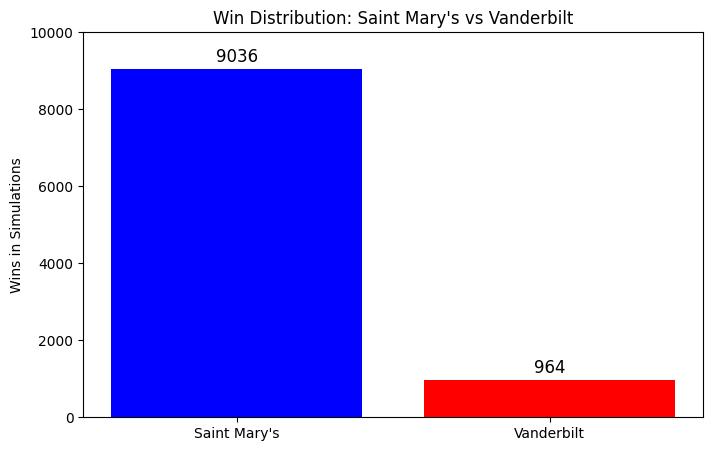


Simulating: Mississippi St. vs Baylor (Seed 8 vs Seed 9)


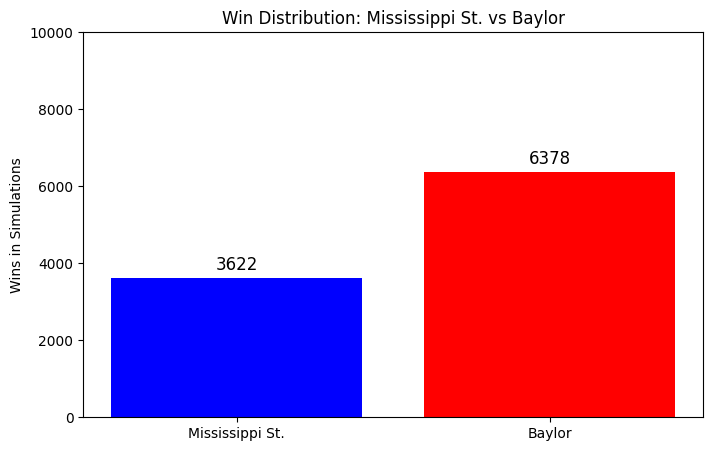


Round 1 winners: ['Duke', 'Alabama', 'Wisconsin', 'Arizona', 'Oregon', 'BYU', "Saint Mary's", 'Baylor']


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Historical seed performance (win probabilities for a seed matchup)
seed_performance = {
    1: 0.987, 2: 0.929, 3: 0.853, 4: 0.788, 5: 0.647, 6: 0.609,
    7: 0.613, 8: 0.481, 9: 0.519, 10: 0.387, 11: 0.391, 12: 0.353,
    13: 0.212, 14: 0.147, 15: 0.071, 16: 0.013
}

def read_matchups_from_excel(file_path):
    df = pd.read_excel(file_path)
    df.columns = df.columns.str.strip()
    df['Win Prob A'] = pd.to_numeric(df['Win Prob A'], errors='coerce')
    df['Win Prob B'] = pd.to_numeric(df['Win Prob B'], errors='coerce')
    df['Team A'] = df['Team A'].astype(str)
    df['Team B'] = df['Team B'].astype(str)
    return df[['Team A', 'Team B', 'Win Prob A', 'Win Prob B', 'Seed A', 'Seed B']]

def get_dynamic_noise(seed_a, seed_b):
    return 0.20 + (0.008 * abs(seed_a - seed_b))

def bias_for_close_matchups(prob_a, prob_b, seed_a, seed_b):
    if min(prob_a, prob_b) >= 0.35:
        seed_advantage = 0.0015 * (seed_b - seed_a)
        prob_a += seed_advantage
        prob_b -= seed_advantage
    return max(0, min(prob_a, 1)), max(0, min(prob_b, 1))

def historical_upset_boost(prob_a, prob_b, seed_a, seed_b):
    upset_spots = {(12, 5): 0.10, (11, 6): 0.07, (10, 7): 0.06, (13, 4): 0.06, (8, 9): 0.05, (7, 10): 0.04, (6, 11): 0.03, (5, 12): 0.06}

    upset_boost = upset_spots.get((min(seed_a, seed_b), max(seed_a, seed_b)), 0)
    if seed_a > seed_b:
        prob_a += upset_boost
        prob_b -= upset_boost
    else:
        prob_b += upset_boost
        prob_a -= upset_boost
    return max(0, min(prob_a, 1)), max(0, min(prob_b, 1))

def simulate_game(win_prob_a, win_prob_b, seed_a, seed_b):
    seed_modifier = (seed_performance.get(seed_a, 0.50) - seed_performance.get(seed_b, 0.50)) * 0.02
    adjusted_prob_a = win_prob_a + seed_modifier * 0.5
    adjusted_prob_b = win_prob_b - seed_modifier * 1.5
    noise_factor = get_dynamic_noise(seed_a, seed_b)
    adjusted_prob_a += np.random.uniform(-noise_factor, noise_factor)
    adjusted_prob_a, adjusted_prob_b = bias_for_close_matchups(adjusted_prob_a, adjusted_prob_b, seed_a, seed_b)
    adjusted_prob_a, adjusted_prob_b = historical_upset_boost(adjusted_prob_a, adjusted_prob_b, seed_a, seed_b)
    return max(0, min(adjusted_prob_a, 1)), 1 - max(0, min(adjusted_prob_a, 1))

def plot_win_distribution(team_a, team_b, win_counts, num_simulations):
    plt.figure(figsize=(8, 5))
    plt.bar([team_a, team_b], [win_counts[0], win_counts[1]], color=['blue', 'red'])
    plt.ylabel("Wins in Simulations")
    plt.title(f"Win Distribution: {team_a} vs {team_b}")
    plt.ylim(0, num_simulations)
    for i, count in enumerate(win_counts):
        plt.text(i, count + num_simulations * 0.02, str(count), ha='center', fontsize=12)
    plt.show()

def simulate_round(matchups, round_number, num_simulations=10000):
    print("\nInitial Matchup Data:")
    print(matchups.to_string(index=False))
    winners = []
    for _, matchup in matchups.iterrows():
        team_a, team_b = matchup['Team A'], matchup['Team B']
        prob_a, prob_b = float(matchup['Win Prob A']), float(matchup['Win Prob B'])
        seed_a, seed_b = matchup['Seed A'], matchup['Seed B']
        print(f"\nSimulating: {team_a} vs {team_b} (Seed {seed_a} vs Seed {seed_b})")
        win_count_a = sum(simulate_game(prob_a, prob_b, seed_a, seed_b)[0] > 0.5 for _ in range(num_simulations))
        win_count_b = num_simulations - win_count_a
        plot_win_distribution(team_a, team_b, [win_count_a, win_count_b], num_simulations)
        winners.append(team_a if win_count_a > win_count_b else team_b)
    print(f"\nRound {round_number} winners: {winners}")
    return winners

file_path = "/Users/kkelley/Desktop/CHE4230Project/CHE4230Project/EMCRD1.xlsx"
matchups_df = read_matchups_from_excel(file_path)
round_1_winners = simulate_round(matchups_df, round_number=1)






